In [1]:
import xarray as xr
import pandas as pd
import seaborn as sns

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, f1_score

# Load Airpublic sensor data from colocation at MY1 AURN station

In [2]:
# load 
df = pd.read_csv('airpublic_colocation_raw_CO_NO.csv')
df.pm10 = df.pm10.astype(float)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.sort_values(by='timestamp')
 

In [3]:
df.head().T

,0,1,2,3,4
Unnamed: 0,2141,2140,2139,2138,2137
altitude,0,0,75,81.3,81
gas_temp,32.7,258.2,255,255,258.2
gps_fix,0,0,1,1,1
heading,3,3,152.1,249.4,285.7
humidity,50,51.1,50.4,50.7,50.7
latitude,0.89,0.39,51.5228,51.5229,51.5229
lonet_bat,93,96,92,94,93
longitude,86.4,69.6,-0.15468,-0.15471,-0.154737
pm1,0.538,0.827,4.072,1.905,1.883


# Convert co voltage to ppb


In [4]:
ANALOG_REF_VOLTAGE = 3.3;
    
# AFE board serial number 12-000027
# sensor CO A4 serial number 132950238

CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 268;
CO_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 42;

CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 262;
CO_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 10;
CO_SENSITIVITY = 0.228; # mv/ppb

def convert_co(CO_working_mv=None, CO_aux_mv=None, temp_correction = +1):
    scaled_working_CO_nA = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8
    scaled_aux_CO_nA  =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8 * temp_correction
    return (scaled_working_CO_nA - scaled_aux_CO_nA) / CO_SENSITIVITY

In [5]:
df['co_ppb'] = df[['raw_CO_working','raw_CO_aux']].apply(lambda x: convert_co(x.values[0], x.values[1]), axis=1)

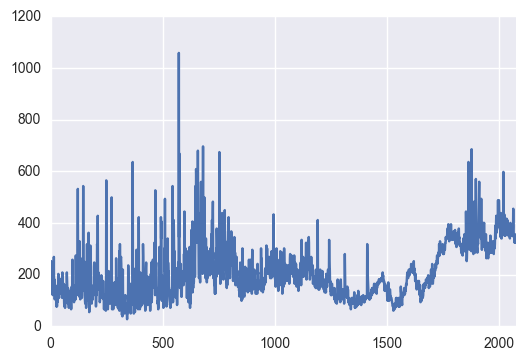

In [6]:
df.co_ppb.plot()

In [7]:
df.co_ppb.describe()

count    2077.000000
mean      204.902868
std       102.765262
min        27.328549
25%       126.169591
50%       180.948963
75%       263.288145
max      1058.099415
Name: co_ppb, dtype: float64

## One hour averages

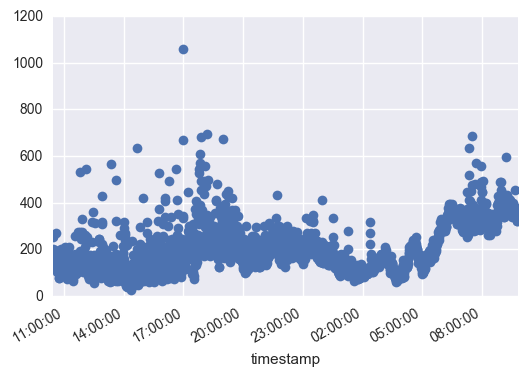

In [8]:
ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').co_ppb.plot(linestyle='none', marker='o')
#ds = ds.set_coords(['timestamp','id'])
#ds = ds.set_coords(['timestamp','id'])

## Compare to kings measurements from MY1 station

In [9]:
# load kings

df_kings_vol = pd.read_csv('my1_volume_18jan.csv')
df_kings_vol['timestamp'] = pd.to_datetime(df_kings_vol.date)

def filter_by_time(df):
    time = (df.timestamp >= '2017-01-17 13:00') & (df.timestamp <= '2017-01-18 12:00')
    return df[time]

# co is in ppm
df_kings_vol.co = 1000 * df_kings_vol.co

df_kings_vol = filter_by_time(df_kings_vol)
df_kings_vol = df_kings_vol.set_index('timestamp')
ds_kings_vol = xr.Dataset.from_dataframe(df_kings_vol)
kings_prefix = dict([(v, 'kings_'+v) for v in ds_kings_vol.data_vars])

def compare(ds_merged, airpublic_measure, kings_measure):
    ds_merged_one = ds_merged[[airpublic_measure, kings_measure]]
    # ds_merged_one['error'] = ds_merged_one[kings_measure] - ds_merged[airpublic_measure]
    #ds_merged_one.sel(datetime=example_date).to_dataframe().plot()
    ds_merged_one.to_dataframe().plot()
    sns.pairplot(ds_merged_one.to_dataframe().dropna().reset_index(), vars=ds_merged_one.data_vars)
    print(ds_merged_one.to_dataframe().describe())

In [10]:
ds_kings_vol.to_dataframe().head()

,Unnamed: 0,date,site,nox,no2,o3,so2,co,pm10_raw,pm10,nv10,code
timestamp,,,,,,,,,,,,
2017-01-17 13:00:00,9182,2017-01-17 13:00:00,Westminster - Marylebone Road,NaN,NaN,NaN,NaN,NaN,64.800450,63.372866,NaN,MY1
2017-01-17 14:00:00,9183,2017-01-17 14:00:00,Westminster - Marylebone Road,295.0899,57.658025,8.059500,5.34600,200.0,47.880333,48.438046,NaN,MY1
2017-01-17 15:00:00,9184,2017-01-17 15:00:00,Westminster - Marylebone Road,330.3483,64.011675,7.412750,5.46975,300.0,57.142215,54.528085,NaN,MY1
2017-01-17 16:00:00,9185,2017-01-17 16:00:00,Westminster - Marylebone Road,272.0574,62.759150,7.885375,4.95000,400.0,52.396728,50.716279,NaN,MY1
2017-01-17 17:00:00,9186,2017-01-17 17:00:00,Westminster - Marylebone Road,306.7182,73.067325,7.611750,4.77675,500.0,53.607645,52.445866,NaN,MY1


         kings_co  co_ppb_modified
count   19.000000        20.000000
mean   492.543860       495.656381
std    221.803333       230.260796
min    200.000000       200.000000
25%    345.833333       320.634188
50%    450.000000       469.834448
75%    537.500000       626.391321
max    950.000000       950.000000


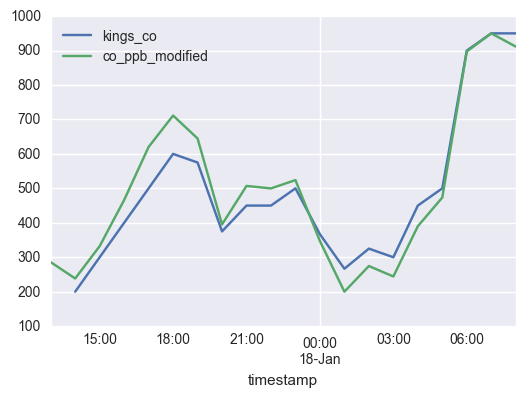

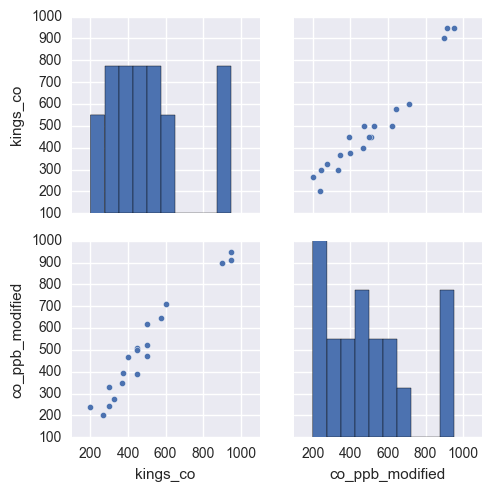

In [11]:
ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')
# normalization
kings_range = ds_merged['kings_co'].max() - ds_merged['kings_co'].min()
our_range = ds_merged['co_ppb'].max() - ds_merged['co_ppb'].min()
factor = kings_range / our_range
translation = ds_merged.kings_co.max() - ds_merged.co_ppb.max() * factor
ds_merged['co_ppb_modified'] = ds_merged['co_ppb'] * factor + translation


compare(ds_merged,'kings_co','co_ppb_modified')

## r2

In [12]:
co_r2_df = pd.DataFrame()
co_r2_df['kings_co'] = ds_merged['kings_co']
co_r2_df['co_ppb'] = ds_merged['co_ppb']
co_r2_df['co_ppb_modified'] = ds_merged['co_ppb_modified']

In [13]:
# r2 score without any scaling or translation
r2_score(co_r2_df.dropna()['kings_co'], co_r2_df.dropna()['co_ppb'])

-1.1872768168986649

In [14]:
# r2 score after some normalization
r2_score(co_r2_df.dropna()['kings_co'], co_r2_df.dropna()['co_ppb_modified'])

0.9304068915487318

## f1 score

In [15]:
# NO2 threshold taken from page 86 of http://www.euro.who.int/__data/assets/pdf_file/0009/128169/e94535.pdf
CO_WHO_THRESHOLD_MICROGRAMS = 10.5 * 10**3 # in micrograms per m3
CO_WHO_THRESHOLD_PPB = CO_WHO_THRESHOLD_MICROGRAMS / 1.145 # convert to ppb
CO_WHO_THRESHOLD_PPB

9170.305676855894

All the readings seem to be well below the threshold...I'll try setting a lower threshold to see the f1 score

In [16]:
CO_WHO_THRESHOLD_PPB = 500

In [17]:
# f1 score without any scaling or translation
f1_score(co_r2_df.dropna()['kings_co'] > CO_WHO_THRESHOLD_PPB, co_r2_df.dropna()['co_ppb'] > CO_WHO_THRESHOLD_PPB)

C:\Miniconda3\envs\complexity-project\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [18]:
# f1 score after some normalization
f1_score(co_r2_df.dropna()['kings_co'] > CO_WHO_THRESHOLD_PPB, co_r2_df.dropna()['co_ppb_modified'] > CO_WHO_THRESHOLD_PPB)

0.76923076923076927

# NO2 conversion

In [19]:
# AFE board serial number 12-000027
# sensor NO2 A43F serial number 212060336
NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 2;
NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 0;
NO2_SENSITIVITY = 0.197; # mv/ppb

def convert_no2(NO2_working_mv=None, NO2_aux_mv=None, temp_correction = +1.09):
    # temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C    
    
    scaled_working_NO2_nA = (NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8
    scaled_aux_NO2_nA = (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8 * temp_correction
    return (scaled_working_NO2_nA -  scaled_aux_NO2_nA ) / NO2_SENSITIVITY

In [20]:
df['no2_ppb'] = df[['raw_NO2_working','raw_NO2_aux']].apply(lambda x: convert_no2(x.values[0], x.values[1]), axis=1)

In [21]:
df.no2_ppb.describe()

count    2077.000000
mean      128.640266
std        10.240371
min        97.653946
25%       123.620166
50%       129.353684
75%       135.654253
max       193.887264
Name: no2_ppb, dtype: float64

## One hour averages

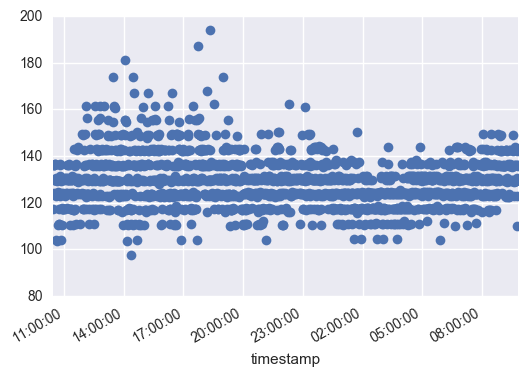

In [22]:
ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').no2_ppb.plot(linestyle='none', marker='o')

## Compare to Kings

       kings_no2  no2_ppb_modified
count  19.000000         20.000000
mean   52.392931         56.730012
std     9.749879         10.711537
min    36.768175         36.768175
25%    45.259812         48.659768
50%    51.498600         57.458254
75%    58.665725         64.878006
max    73.067325         73.067325


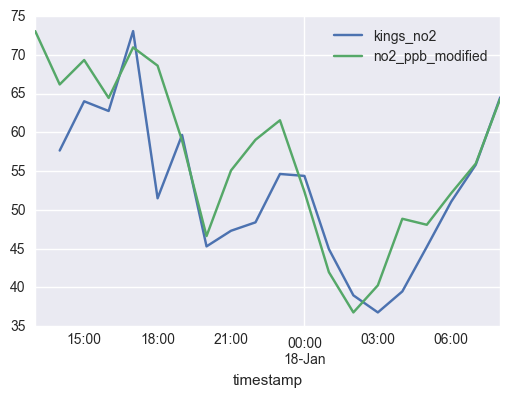

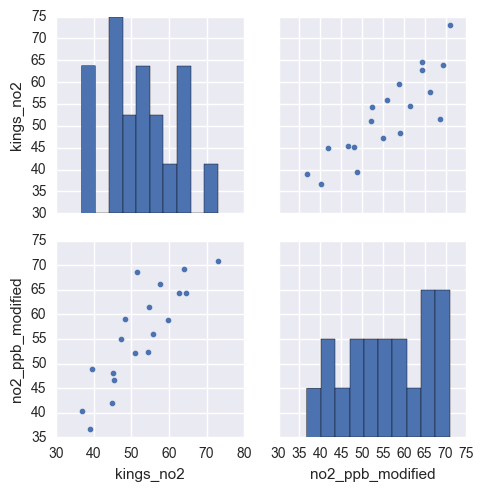

In [23]:
ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')
# normalization for better comparison
kings_range = ds_merged['kings_no2'].max() - ds_merged['kings_no2'].min()
our_range = ds_merged['no2_ppb'].max() - ds_merged['no2_ppb'].min()
factor = kings_range / our_range
translation = ds_merged.kings_no2.max() - ds_merged.no2_ppb.max() * factor
ds_merged['no2_ppb_modified'] = ds_merged['no2_ppb'] * factor + translation
compare(ds_merged,'kings_no2','no2_ppb_modified')

## r2

In [24]:
no2_r2_df = pd.DataFrame()
no2_r2_df['kings_no2'] = ds_merged['kings_no2']
no2_r2_df['no2_ppb'] = ds_merged['no2_ppb']
no2_r2_df['no2_ppb_modified'] = ds_merged['no2_ppb_modified']
no2_r2_df.dropna()

,kings_no2,no2_ppb,no2_ppb_modified
1,57.658025,132.124766,66.185240
2,64.011675,133.347523,69.336368
3,62.759150,131.448424,64.442261
4,73.067325,133.978718,70.963000
5,51.498600,133.065583,68.609789
6,59.673425,129.315552,58.945705
7,45.290700,124.533224,46.621318
8,47.305525,127.817680,55.085585
9,48.391875,129.354064,59.044951
10,54.633875,130.330683,61.561767


In [25]:
# r2 score without any scaling or translation
r2_score(no2_r2_df.dropna()['kings_no2'], no2_r2_df.dropna()['no2_ppb'])

-63.147938305397929

In [26]:
# r2 score after some normalization
r2_score(no2_r2_df.dropna()['kings_no2'], no2_r2_df.dropna()['no2_ppb_modified'])

0.56004670947704371

## f1 score

In [27]:
# NO2 threshold taken from page 17 of http://apps.who.int/iris/bitstream/10665/69477/1/WHO_SDE_PHE_OEH_06.02_eng.pdf
NO2_WHO_THRESHOLD_MICROGRAMS = (40 + 200) / 2. # in micrograms per m3
NO2_WHO_THRESHOLD_PPB = NO2_WHO_THRESHOLD_MICROGRAMS / 1.88
NO2_WHO_THRESHOLD_PPB

63.829787234042556

In [28]:
# f1 score without any scaling or translation
f1_score(no2_r2_df.dropna()['kings_no2'] > NO2_WHO_THRESHOLD_PPB, no2_r2_df.dropna()['no2_ppb'] > NO2_WHO_THRESHOLD_PPB)

0.27272727272727271

In [29]:
# f1 score after some normalization
f1_score(no2_r2_df.dropna()['kings_no2'] > NO2_WHO_THRESHOLD_PPB, no2_r2_df.dropna()['no2_ppb_modified'] > NO2_WHO_THRESHOLD_PPB)

0.66666666666666663